In [1]:
import cv2
import numpy as np
import face_recognition

import matplotlib.pyplot as plt
%matplotlib inline

**Define functions**

In [25]:
# points surrounding a feature like a circle, so middle is right side
def get_middle(points):
    length = len(points)
    if length <= 2:
        return points[0]
    index = round(length/2)
    return points[index]
    
def nose_bridge(points):
    return [points[-1]]

def chin(points):
    return [get_middle(points)]

def left_eye_left_corner(points):
    return [points[0]]

def right_eye_right_corner(points):
    return [get_middle(points)]

def left_right_mouth_corner(points):
    return [points[0],get_middle(points)]


# 2D image points. If you change the image, you need to change vector
# image_points = np.array([
#     (359, 391),     # Nose tip
#     (399, 561),     # Chin
#     (337, 297),     # Left eye left corner
#     (513, 301),     # Right eye right corner
#     (345, 465),     # Left Mouth corner
#     (453, 469)      # Right mouth corner
# ], dtype="double")
features_ordered = [
    ('nose_bridge', nose_bridge),
    ('chin', chin),
    ('left_eye', left_eye_left_corner),
    ('right_eye', right_eye_right_corner),
    ('top_lip', left_right_mouth_corner)
]


# Find all facial features in all the faces in the image
def face_points(image):
#     points_list = []
    face_landmarks_list = face_recognition.face_landmarks(image)
#     for face_landmarks in face_landmarks_list:
     
    if len(face_landmarks_list) == 0:
        return None
    points = []
    face_landmarks = face_landmarks_list[0]
    for facial_feature,func in features_ordered:
        feature_points = face_landmarks[facial_feature]              
        points.extend(func(feature_points))
#         points_list.append(points)
#     return points_list
    return points

In [26]:

# image_points_list = []
# for points in points_list:
#     image_points = np.array(points, dtype='double')
#     image_points_list.append(image_points)

# 3D model points.
model_points = np.array([
    (0.0, 0.0, 0.0),             # Nose tip
    (0.0, -330.0, -65.0),        # Chin
    (-225.0, 170.0, -135.0),     # Left eye left corner
    # Right eye right corne
    (225.0, 170.0, -135.0),
    (-150.0, -150.0, -125.0),    # Left Mouth corner
    (150.0, -150.0, -125.0)      # Right mouth corner

])

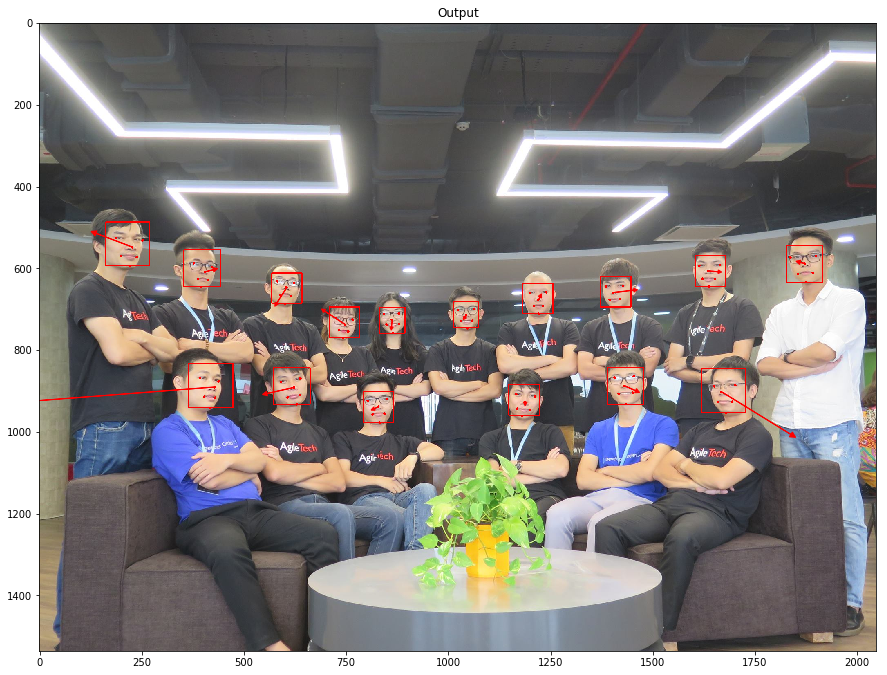

In [28]:
# Read Image
im = cv2.imread("agiletech.jpg")
size_list = face_recognition.face_locations(im)
# points_list = face_points(im)
# print(size_list)

plt.figure(figsize=[15,15])
plt.title("Output")

frame = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
color = (255, 0, 0)
color_hex = '#%02x%02x%02x' % color

for index, (top, right, bottom, left) in enumerate(size_list):
#     size = im.shape
    size = [bottom-top, right-left]
    # Camera internals
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

#     print ("Camera Matrix :\n {0}".format(camera_matrix))
    
    sub_im = frame[top:bottom, left:right]
    points = face_points(sub_im)
    if points == None:
        continue
        
    image_points = np.array(points, dtype='double')

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points,
                                                                  image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

#     print ("Rotation Vector:\n {0}".format(rotation_vector))
#     print ("Translation Vector:\n {0}".format(translation_vector))


    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose

    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array(
        [(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    

    p1 = (int(left + image_points[0][0]), int(top + image_points[0][1]))
    p2 = (int(left + nose_end_point2D[0][0][0]), int(top + nose_end_point2D[0][0][1]))
    
    # cv2.line(frame, p1, p2, (255, 0, 0), 4)
#     cv2.arrowedLine(frame, p1, p2, (255, 0, 0), 4)
    arrow_size=round(size[0]/8)
    # Draw a box around the face
    cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
    
    
    # Draw arrow
    plt.arrow(p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1], 
              head_width=arrow_size, head_length=arrow_size, color=color_hex)
    
    # Draw dot
    for p in image_points:
        cv2.circle(frame, (int(left+p[0]), int(top+p[1])), 3, color, -1)

# # ::-1 mean start from -1 and reverse to 0, so bgr => rgb
# frame = im[:, :, ::-1]
# Display image
plt.imshow(frame)
# plt.show()
